In [2]:
import numpy as np
from easydict import EasyDict
from collections import defaultdict
from sksurv.metrics import concordance_index_ipcw

import torch # For building the networks 
import torchtuples as tt # Some useful functions

from pycox.models import PCHazard


In [3]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [4]:
from survtrace.dataset import load_data

# define the setup parameters
pc_hazard_config = EasyDict({
    'data': 'metabric',
    'horizons': [.25, .5, .75],
    'batch_size': 64,
    'learning_rate': 0.01,
    'epochs': 50,
    'hidden_size': 32
})
# pc_hazard_config = EasyDict({
#     'data': 'support',
#     'horizons': [.25, .5, .75],
#     'batch_size': 128,
#     'learning_rate': 0.01,
#     'epochs': 50,
#     'hidden_size': 32
# })
# pc_hazard_config = EasyDict({
#     'data': 'seer',
#     'horizons': [.25, .5, .75],
#     'batch_size': 1024,
#     'learning_rate': 0.01,
#     'epochs': 100,
#     'hidden_size': 32
# })
# event_0: Heart Disease
# event_1: Breast Cancer
event_to_censor = 'event_0'


# load data
df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = load_data(pc_hazard_config)

# censor event
if pc_hazard_config.data == 'seer':

    censor_event = lambda df: df.drop(event_to_censor, axis=1).rename(columns={event_to_keep: 'event'})

    event_to_keep = '0' if event_to_censor.split('_')[1] == '1' else '1'
    event_to_keep = 'event_' + event_to_keep

    df = censor_event(df)
    df_y_train = censor_event(df_y_train)
    df_y_val = censor_event(df_y_val)
    df_y_test = censor_event(df_y_test)


x_train = np.array(df_train, dtype='float32')
x_val = np.array(df_val, dtype='float32')
x_test = np.array(df_test, dtype='float32')

y_df_to_tuple = lambda df: tuple([np.array(df['duration'], dtype='int64'), np.array(df['event'], dtype='float32'), np.array(df['proportion'], dtype='float32')])

y_train = y_df_to_tuple(df_y_train)
y_val = y_df_to_tuple(df_y_val)

/home/bxjxrx7/dlh_project/SurvTRACE/survtrace/utils.py:78: UserWarning: Got event/censoring at start time. Should be removed! It is set s.t. it has no contribution to loss.
  warnings.warn("""Got event/censoring at start time. Should be removed! It is set s.t. it has no contribution to loss.""")


In [5]:
pc_hazard_config

{'data': 'metabric',
 'horizons': [0.25, 0.5, 0.75],
 'batch_size': 64,
 'learning_rate': 0.01,
 'epochs': 50,
 'hidden_size': 32,
 'labtrans': <survtrace.utils.LabelTransform at 0x7f78325a4390>,
 'num_numerical_feature': 5,
 'num_categorical_feature': 4,
 'num_feature': 9,
 'vocab_size': 8,
 'duration_index': array([  0.        ,  42.68333435,  85.8666687 , 145.33333588,
        355.20001221]),
 'out_feature': 4}

In [6]:
hidden_size = pc_hazard_config.hidden_size
batch_norm = True
dropout = 0.1

net = torch.nn.Sequential(
    torch.nn.Linear(pc_hazard_config.num_feature, hidden_size),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(hidden_size),
    torch.nn.Dropout(0.1),
    
    torch.nn.Linear(hidden_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(hidden_size),
    torch.nn.Dropout(0.1),
    
    torch.nn.Linear(hidden_size, pc_hazard_config.out_feature)
)

In [8]:
model = PCHazard(net, tt.optim.Adam, duration_index=np.array(pc_hazard_config['duration_index'], dtype='float32'))
model.optimizer.set_lr(pc_hazard_config.learning_rate)

In [9]:
callbacks = [tt.callbacks.EarlyStopping(patience=20)]
log = model.fit(x_train, y_train, pc_hazard_config.batch_size, pc_hazard_config.epochs, callbacks, val_data=tuple([x_val, y_val]))


0:	[1s / 1s],		train_loss: 1.6322,	val_loss: 1.4684
1:	[0s / 1s],		train_loss: 1.2376,	val_loss: 1.0884
2:	[0s / 2s],		train_loss: 1.1504,	val_loss: 1.0509
3:	[0s / 2s],		train_loss: 1.1538,	val_loss: 1.0749
4:	[0s / 2s],		train_loss: 1.1223,	val_loss: 1.0468
5:	[0s / 2s],		train_loss: 1.1185,	val_loss: 1.0677
6:	[0s / 2s],		train_loss: 1.1120,	val_loss: 1.0595
7:	[0s / 2s],		train_loss: 1.1009,	val_loss: 1.0762
8:	[0s / 3s],		train_loss: 1.1094,	val_loss: 1.0606
9:	[0s / 3s],		train_loss: 1.0933,	val_loss: 1.0801
10:	[0s / 3s],		train_loss: 1.1030,	val_loss: 1.0608
11:	[0s / 3s],		train_loss: 1.0987,	val_loss: 1.0774
12:	[0s / 3s],		train_loss: 1.0945,	val_loss: 1.0534
13:	[0s / 3s],		train_loss: 1.0985,	val_loss: 1.0466
14:	[0s / 4s],		train_loss: 1.0816,	val_loss: 1.0566
15:	[0s / 4s],		train_loss: 1.0822,	val_loss: 1.0878
16:	[0s / 4s],		train_loss: 1.0815,	val_loss: 1.0633
17:	[0s / 4s],		train_loss: 1.0882,	val_loss: 1.0396
18:	[0s / 4s],		train_loss: 1.0868,	val_loss: 1.0578
19:

<AxesSubplot:>

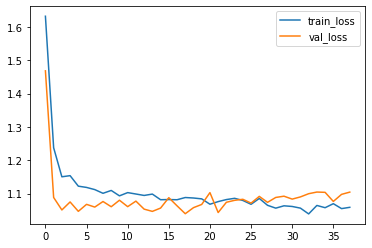

In [10]:
log.plot()

In [11]:
class Evaluator:
    def __init__(self, df, train_index):
        '''the input duration_train should be the raw durations (continuous),
        NOT the discrete index of duration.
        '''
        self.df_train_all = df.loc[train_index]

    def eval_single(self, model, test_set, config, val_batch_size=None):
        df_train_all = self.df_train_all
        get_target = lambda df: (df['duration'].values, df['event'].values)
        durations_train, events_train = get_target(df_train_all)
        print('durations_train', durations_train)
        et_train = np.array([(events_train[i], durations_train[i]) for i in range(len(events_train))],
                        dtype = [('e', bool), ('t', float)])
        print('et_train', et_train)
        times = config['duration_index'][1:-1]
        print('times', times)
        horizons = config['horizons']

        df_test, df_y_test = test_set
        surv = model.predict_surv_df(df_test, batch_size=val_batch_size)
        risk = np.array((1 - surv).transpose())
        print('risk', risk)
        
        durations_test, events_test = get_target(df_y_test)
        print('durations_test', durations_test)
        print('events_test', events_test)
        et_test = np.array([(events_test[i], durations_test[i]) for i in range(len(events_test))],
                    dtype = [('e', bool), ('t', float)])
        print('et_test', et_test)
        metric_dict = defaultdict(list)
        cis = []
        for i, _ in enumerate(times):
            print('iteration', i)
            print('risk', risk[:, i+1])
            print(times)
            cis.append(
                concordance_index_ipcw(et_train, et_test, estimate=risk[:, i+1], tau=times[i])[0]
                )
            metric_dict[f'{horizons[i]}_ipcw'] = cis[i]


        for horizon in enumerate(horizons):
            print(f"For {horizon[1]} quantile,")
            print("TD Concordance Index - IPCW:", cis[horizon[0]])
        
        return metric_dict

In [12]:
evaluator = Evaluator(df, df_train.index)
evaluator.eval_single(model, (x_test, df_y_test), config=pc_hazard_config, val_batch_size=10000)

durations_train [ 95.73333  140.23334  239.3      ...  19.166666 198.43333  140.76666 ]
et_train [( True,  95.73332977) (False, 140.2333374 ) (False, 239.30000305) ...
 ( True,  19.16666603) (False, 198.43333435) (False, 140.7666626 )]
times [ 42.68333435  85.8666687  145.33333588]
risk [[0.         0.25159913 0.4696976  0.85386187 0.99940264]
 [0.         0.0297066  0.09311497 0.22557688 0.72225153]
 [0.         0.12644798 0.2972325  0.44427133 0.8071415 ]
 ...
 [0.         0.26744413 0.6132184  0.873616   0.99896   ]
 [0.         0.3324083  0.41620648 0.50525004 0.73740375]
 [0.         0.12229002 0.2395401  0.4071386  0.7573675 ]]
durations_test [176.26666    176.76666    241.26666     81.333336    90.13333
  37.366665   185.          84.2         78.46667    168.26666
 125.7         72.46667    111.7        147.76666    235.4
 228.6        131.13333    104.53333     12.4         81.066666
 271.26666    163.86667     62.633335    63.033333   136.46666
  21.166666    88.23333    145.

defaultdict(list,
            {'0.25_ipcw': 0.7106630003010055,
             '0.5_ipcw': 0.6973469423115167,
             '0.75_ipcw': 0.6734319767459619})